https://www.kaggle.com/c/titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Starting performs, new features

In [3]:
df.isnull().sum()[df.isnull().sum() > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [4]:
len(df.PassengerId.unique()) == df.shape[0] # True
df.drop('PassengerId', axis = 1, inplace = True)

In [5]:
(df.Ticket.nunique())/df.shape[0] # delete feature ticket not bad idea, proportion of distinct values is high

0.7643097643097643

In [6]:
df['Family'] = df.SibSp + df.Parch
df['Greeting'] = df.Name.apply(lambda name: name[name.index(',') + 1 : name.index('.')])
df['Lone_male_passenger'] = np.where((df['Family'] == 0) & (df['Sex'] == 'male'), 1, 0)
df['Not_alone_male_passenger'] = np.where((df['Family'] != 0) & (df['Sex'] == 'male') & (df['Age'] > 20), 1, 0)

## Fill the gaps

Age         177
Cabin       687
Embarked      2
dtype: int64

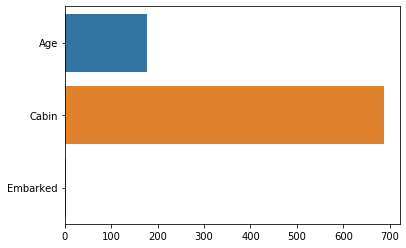

In [7]:
sns.barplot(x = df.isnull().sum()[df.isnull().sum() > 0].values, y = df.isnull().sum()[df.isnull().sum() > 0].index)
df.isnull().sum()[df.isnull().sum() > 0]

In [8]:
print('Known values of cabins:', df[df.Cabin.notnull()].Survived.sum()/df[df.Cabin.notnull()].shape[0])
print('Nans-values of cabins:', df[df.Cabin.isnull()].Survived.sum()/df[df.Cabin.isnull()].shape[0])

Known values of cabins: 0.6666666666666666
Nans-values of cabins: 0.29985443959243085


In [9]:
df['Known_Cabin'] = df.Cabin.notnull()
df.Cabin.fillna('N', inplace = True)
df.Cabin = df.Cabin.apply(lambda x: x[0])

In [10]:
df.Embarked.fillna(df.Embarked.mode()[0], inplace = True)

In [11]:
greet_na = df.Greeting[df.Age.isnull()].value_counts().index
dit = {x: df[(df['Greeting'] == x) & (df.Age.notnull())].Age.median() for x in greet_na}
for i in df.index:
    if df.loc[i, 'Age'] != df.loc[i, 'Age']:
        df.loc[i, 'Age'] = dit[df.loc[i, 'Greeting']]

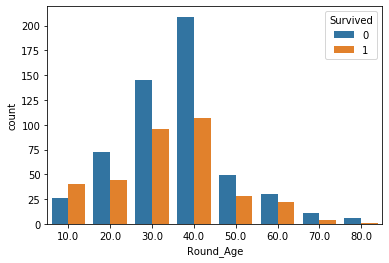

In [12]:
df['Round_Age'] = np.around(df['Age'] + 5, -1)
sns.countplot(df['Round_Age'], hue = df.Survived)

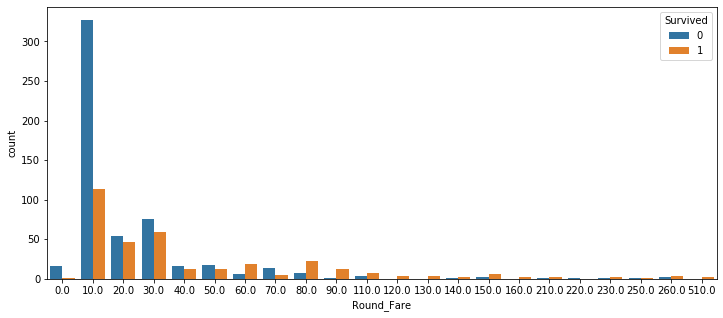

In [13]:
plt.figure(figsize = (12, 5))
df['Round_Fare'] = np.around(df.Fare, -1)
sns.countplot(df['Round_Fare'], hue = df.Survived)

def cat_fare(mas):
    cat = np.where(mas <= 10, 1, mas)
    cat = np.where((cat == 20) | (cat == 30), 2, cat)
    cat = np.where((cat == 40) | (cat == 50), 3, cat)
    cat = np.where((cat == 60) | (cat >= 80), 5, cat)
    cat = np.where((cat == 70), 4, cat)
    
    return cat.astype('str')

df['Round_Fare'] = cat_fare(np.around(df.Fare, -1))

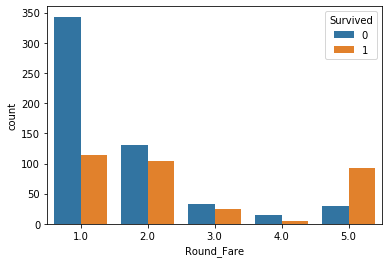

In [14]:
sns.countplot(df['Round_Fare'], hue = df.Survived)

## Visualisation features

### Barplots

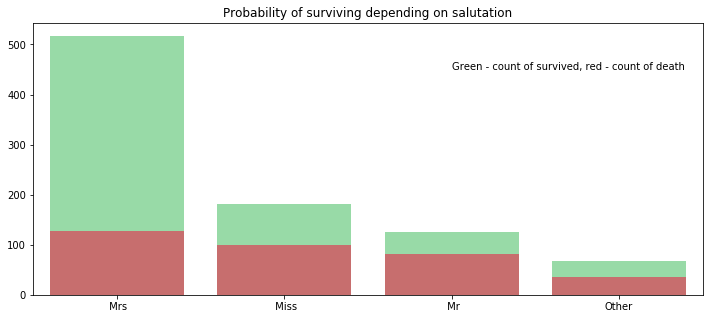

In [15]:
plt.figure(figsize = (12, 5))
df.Greeting = df.Greeting.apply(lambda x: x if x in df.Greeting.value_counts()[:3] else 'Other')
df.Greeting.value_counts()
sns.set_color_codes("pastel")
sns.barplot(x = df.Greeting.unique(), y = df.Greeting.value_counts().values, color = 'g')

sns.set_color_codes("muted")
sns.barplot(x = df[df.Survived == 1].Greeting.unique(), y = df[df.Survived == 1].Greeting.value_counts().values, color = 'r')
plt.title('Probability of surviving depending on salutation')
plt.text(2, 450, s = 'Green - count of survived, red - count of death')
plt.show()

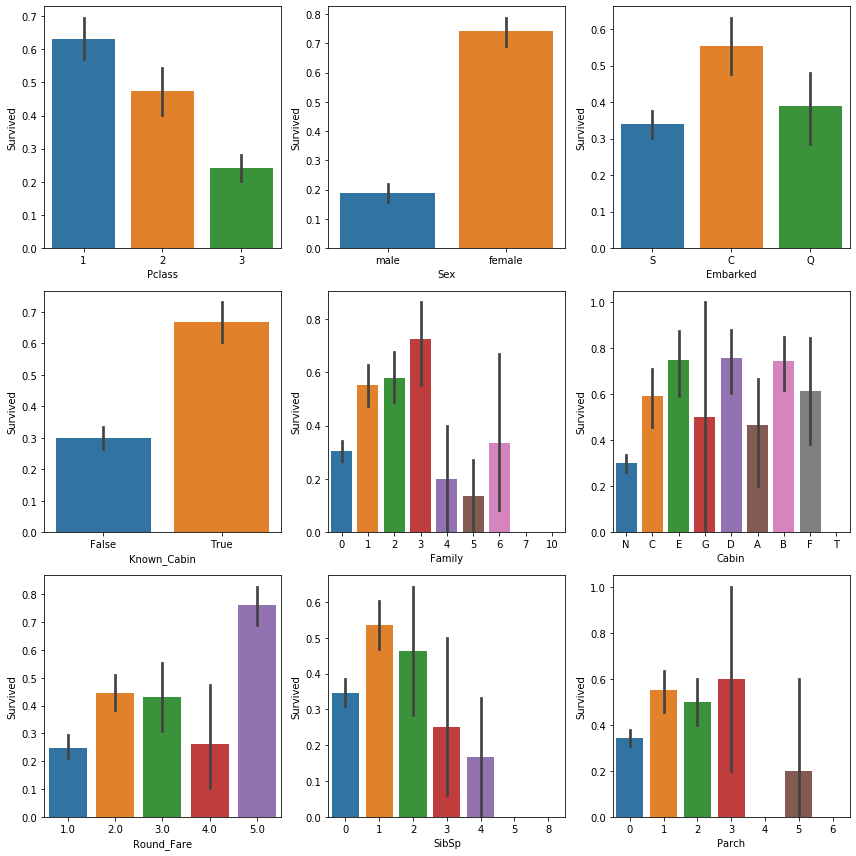

In [16]:
i = 0
plt.figure(figsize = (12, 12))
for column in ['Pclass', 'Sex', 'Embarked', 'Known_Cabin', 'Family', 'Cabin', 'Round_Fare', 'SibSp', 'Parch']:
    i += 1
    pylab.subplot(3, 3, i)
    sns.barplot(x = column, y = 'Survived', data = df)
    plt.tight_layout()

All features, except cabin, have different proportion of survived in target classes

### Distribution plots

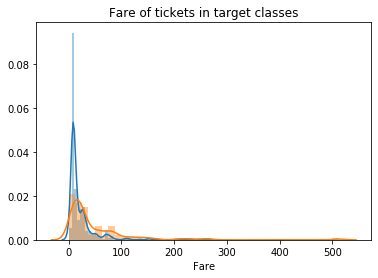

In [17]:
sns.distplot(df[df.Survived == 0].Fare)
sns.distplot(df[df.Survived == 1].Fare)
plt.title('Fare of tickets in target classes')
plt.show()

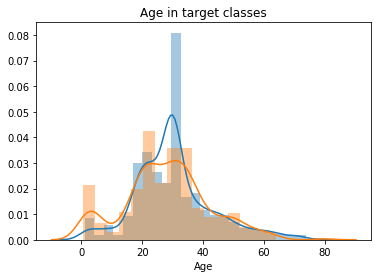

In [18]:
sns.distplot(df[df.Survived == 0].Age)
sns.distplot(df[df.Survived == 1].Age)
plt.title('Age in target classes')
plt.show()

## Preparing features for model

In [19]:
df.drop(['Ticket', 'Greeting', 'Cabin', 'Name', 'Family', 'Age', 'Fare'], axis = 1, inplace = True)

In [20]:
cat_fs = df.select_dtypes('O')

In [21]:
new_df = pd.concat([df, pd.get_dummies(cat_fs)], axis = 1)
new_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Lone_male_passenger,Not_alone_male_passenger,Known_Cabin,Round_Age,...,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Round_Fare_1.0,Round_Fare_2.0,Round_Fare_3.0,Round_Fare_4.0,Round_Fare_5.0
0,0,3,male,1,0,S,0,1,False,30.0,...,0,1,0,0,1,1,0,0,0,0
1,1,1,female,1,0,C,0,0,True,40.0,...,1,0,1,0,0,0,0,0,1,0
2,1,3,female,0,0,S,0,0,False,30.0,...,1,0,0,0,1,1,0,0,0,0
3,1,1,female,1,0,S,0,0,True,40.0,...,1,0,0,0,1,0,0,1,0,0
4,0,3,male,0,0,S,1,0,False,40.0,...,0,1,0,0,1,1,0,0,0,0


In [22]:
new_df.drop(['Sex', 'Embarked', 'Round_Fare'], axis =1, inplace = True)

In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Survived                  891 non-null    int64  
 1   Pclass                    891 non-null    int64  
 2   SibSp                     891 non-null    int64  
 3   Parch                     891 non-null    int64  
 4   Lone_male_passenger       891 non-null    int32  
 5   Not_alone_male_passenger  891 non-null    int32  
 6   Known_Cabin               891 non-null    bool   
 7   Round_Age                 891 non-null    float64
 8   Sex_female                891 non-null    uint8  
 9   Sex_male                  891 non-null    uint8  
 10  Embarked_C                891 non-null    uint8  
 11  Embarked_Q                891 non-null    uint8  
 12  Embarked_S                891 non-null    uint8  
 13  Round_Fare_1.0            891 non-null    uint8  
 14  Round_Fare

## Random forest and grad boosting

In [24]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, make_scorer, accuracy_score

### Baseline

In [25]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('Survived', axis = 1), new_df['Survived'], test_size = 0.25)

In [26]:
cls_forest = RandomForestClassifier()
cls_xgb = xgb.XGBClassifier(booster = 'gbtree')
scoring = {'f1': make_scorer(f1_score), 'ROC_AUC': make_scorer(roc_auc_score), 'accure': make_scorer(accuracy_score)}
CV = StratifiedShuffleSplit(test_size = 0.3)

In [27]:
score_cross_xgb = cross_validate(cls_xgb, X_train, y_train, scoring = scoring, cv = CV)

print('xgb, f1-score:', np.around(score_cross_xgb['test_f1'], decimals = 3), 
                'mean:', np.around(score_cross_xgb['test_f1'], decimals = 3).mean())

print('xgb, roc_auc-score:', np.around(score_cross_xgb['test_ROC_AUC'], decimals = 3),
                     'mean:', np.around(score_cross_xgb['test_ROC_AUC'], decimals = 3).mean())

print('xgb, accuracy-score:', np.around(score_cross_xgb['test_accure'], decimals = 3),
                     'mean:', np.around(score_cross_xgb['test_accure'], decimals = 3).mean())

xgb, f1-score: [0.748 0.803 0.803 0.742 0.766 0.781 0.786 0.735 0.774 0.72 ] mean: 0.7657999999999999
xgb, roc_auc-score: [0.797 0.839 0.84  0.791 0.81  0.823 0.825 0.788 0.817 0.774] mean: 0.8103999999999999
xgb, accuracy-score: [0.826 0.856 0.851 0.806 0.836 0.836 0.851 0.821 0.826 0.791] mean: 0.8299999999999998


In [28]:
score_cross_forest = cross_validate(cls_forest, X_train, y_train, scoring = scoring, cv = CV)

print('forest, f1-score:', np.around(score_cross_forest['test_f1'], decimals = 3), 
                                                      'mean:', np.around(score_cross_forest['test_f1'], decimals = 3).mean())

print('forest, roc_auc-score:', np.around(score_cross_forest['test_ROC_AUC'], decimals = 3),
                                                 'mean:', np.around(score_cross_forest['test_ROC_AUC'], decimals = 3).mean())

print('forest, accuracy-score:', np.around(score_cross_forest['test_accure'], decimals = 3),
                                                 'mean:', np.around(score_cross_forest['test_accure'], decimals = 3).mean())

forest, f1-score: [0.731 0.737 0.757 0.731 0.776 0.772 0.718 0.707 0.764 0.687] mean: 0.7380000000000001
forest, roc_auc-score: [0.784 0.787 0.803 0.784 0.819 0.815 0.771 0.764 0.809 0.754] mean: 0.789
forest, accuracy-score: [0.806 0.801 0.821 0.806 0.831 0.836 0.781 0.781 0.831 0.791] mean: 0.8085000000000001


There is'nt significant differences between two models, that way I'll train both models

### Forest

In [30]:
cls_forest = RandomForestClassifier()
CV = StratifiedShuffleSplit(test_size = 0.3)
params = {'n_estimators': [2000], 'max_depth': [2, 3]}
grid_search = GridSearchCV(cls_forest, params, cv = CV, scoring = make_scorer(f1_score), n_jobs = -1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop('Survived', axis = 1), new_df['Survived'], test_size = 0.25)

In [32]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.3,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
    

In [33]:
bst_est_forest = grid_search.best_estimator_
print('Best_params: ', grid_search.best_params_)
print('Best_score: ', grid_search.best_score_)

Best_params:  {'max_depth': 3, 'n_estimators': 2000}
Best_score:  0.6879496314831414


In [34]:
y_pred = bst_est_forest.predict(X_test)

In [35]:
print('Matrix of TP, FP, FN, TN:\n', confusion_matrix(y_test, y_pred))
print('F-score:', f1_score(y_test, y_pred))
print('ROC_AUC-score:', roc_auc_score(y_test, y_pred))

Matrix of TP, FP, FN, TN:
 [[128  17]
 [ 23  55]]
F-score: 0.7333333333333334
ROC_AUC-score: 0.7939434129089302


### Gradient boosting trees

In [36]:
cls_xgb = xgb.XGBClassifier()

params = {'n_estimators': list(range(70, 500, 30)), 'max_depth': [2, 3, 4], 'booster': ['gbtree', 'dart'],
          'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'eta': [0.01, 0.05, 0.1, 0.5, 1]}
rand_search_xgb = RandomizedSearchCV(cls_xgb, params, cv = CV, scoring = make_scorer(roc_auc_score), n_jobs = -1)

In [37]:
rand_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.3,
            train_size=None),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, n...
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'eta': [0.01, 0.05, 0.1, 0.5, 1],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_leaf': [2, 3, 4

In [38]:
bst_est_xgb = rand_search_xgb.best_estimator_
print('Best_params:', rand_search_xgb.best_params_)
print('Best_score:', rand_search_xgb.best_score_)

Best_params: {'n_estimators': 370, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2, 'eta': 0.1, 'booster': 'dart'}
Best_score: 0.8217731894583938


In [39]:
y_pred = bst_est_xgb.predict(X_test)
print('Matrix of TP, FP, FN, TN:\n', confusion_matrix(y_test, y_pred))
print('F-score:', f1_score(y_test, y_pred))
print('ROC_AUC-score:', roc_auc_score(y_test, y_pred))

Matrix of TP, FP, FN, TN:
 [[129  16]
 [ 19  59]]
F-score: 0.7712418300653594
ROC_AUC-score: 0.8230327144120247


## Solution on test sample

In [40]:
test_df = pd.read_csv('test.csv')
test_df.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)
test_df.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S


In [41]:
med = test_df.Fare.median()
test_df.Fare = test_df.Fare.apply(lambda x: med if x!=x else x)

In [42]:
test_df['Family'] = test_df.SibSp + test_df.Parch
test_df['Greeting'] = test_df.Name.apply(lambda name: name[name.index(',') + 1 : name.index('.')])
test_df['Known_Cabin'] = test_df.Cabin.notnull()


test_df['Round_Fare'] = cat_fare(np.around(test_df.Fare, -1))
test_df['Round_Age'] = np.around(test_df.Age, -1)
test_df['Lone_male_passenger'] = np.where((test_df['Family'] == 0) & (test_df['Sex'] == 'male'), 1, 0)
test_df['Not_alone_male_passenger'] = np.where((test_df['Family'] != 0) & (test_df['Sex'] == 'male') & (test_df['Age'] > 20), 1, 0)

greet_na = test_df.Greeting[test_df.Age.isnull()].value_counts().index
dit = {x: test_df[(test_df['Greeting'] == x) & (test_df.Age.notnull())].Age.median() for x in greet_na}
for i in test_df.index:
    if test_df.loc[i, 'Age'] != test_df.loc[i, 'Age']:
        test_df.loc[i, 'Age'] = dit[test_df.loc[i, 'Greeting']]
      
test_df.drop(['Greeting', 'Cabin', 'Name', 'Family', 'Age', 'Fare'], axis = 1, inplace = True)

cat_fs = test_df.select_dtypes('O')
new_test_df = pd.concat([test_df, pd.get_dummies(cat_fs)], axis = 1)
new_test_df.drop(['Embarked', 'Sex', 'Round_Fare'], axis = 1, inplace = True)

In [44]:
x_test = new_test_df
y_pred = bst_est_forest.predict(x_test)

In [154]:
answer = pd.DataFrame({'PassengerId': list(range(892, 891+419)), 'Survived': y_pred})
answer

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [155]:
answer.to_csv('Answer_titanic', index = False)

Идеи для создания признаков: 
* сделать признак-индикатор одинок ли пассажир, 
* является ли взрослым мужчиной


ошибка состоит из 3 частей: шум, смещение, разброс. Ошибка алгоритма реш деревьев обладает низким смещением, но высоким рзбросом. Чтобы избежать высокой дисперсии ошибок алгоритма необходимо сделать деревья в композиции более независимыми (менее коррелироваными) .
С этой задачей могут справится беггинг и метод случайных подпространств. (Взять не n признаков, а корень из n признаков)
файл 4-2 в конспектах с курсеры